### import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [5]:
import alpaca_trade_api as tradeapi

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Initialize the API
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [6]:
tickers = ["AGG", "SPY"]

timeframe = '1D'
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.droplevel(axis=1, level=0)
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df.index = df.index.date
#cross-referenced close dates to last year and subbed in correct tickers as column names
columns=["AGG", "SPY"]
df.columns = columns
df.head()

,AGG,SPY
2019-12-05,112.69,312.05
2019-12-06,112.54,314.84
2019-12-09,112.58,313.87
2019-12-10,112.54,313.55
2019-12-11,112.84,314.41


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns_AGG = daily_returns['AGG']
daily_returns_SPY = daily_returns['SPY']
avg_return_AGG = daily_returns_AGG.mean()
avg_return_SPY = daily_returns_SPY.mean()

In [8]:
# Calculate volatility
std_dev = daily_returns.std()
std_dev_AGG = std_dev['AGG']
std_dev_SPY = std_dev['SPY']

In [9]:
# Save the last day's closing price
last_close_AGG = df['AGG'][-1]
last_close_SPY = df['SPY'][-1]
print(last_close_AGG, last_close_SPY)

117.43 293.19


In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo_price_df = pd.DataFrame()
monte_carlo_cum_returns_df = pd.DataFrame()


In [11]:
# Run the Monte Carlo Simulation
    
for x in range(number_simulations):
    simulated_prices_AGG = [last_close_AGG]
    simulated_prices_SPY = [last_close_SPY]
    
    for _ in range(number_records):
        

        simulated_price_AGG = simulated_prices_AGG[-1] * (1 + np.random.normal(avg_return_AGG, std_dev_AGG))
        simulated_price_SPY = simulated_prices_SPY[-1] * (1 + np.random.normal(avg_return_SPY, std_dev_SPY))
        
        
        simulated_prices_AGG.append(simulated_price_AGG)
        simulated_prices_SPY.append(simulated_price_SPY)
    
    
    monte_carlo_price_df["AGG prices"] = pd.Series(simulated_prices_AGG)
    monte_carlo_price_df["SPY prices"] = pd.Series(simulated_prices_SPY)
    
   
    monte_carlo_daily_returns = monte_carlo_price_df.pct_change()
    
    #portfolio weights (40% AGG; 60% SPY for 40%/60% bond/stock portfolio
    weights = [0.40, 0.60]

    weighted_monte_carlo_daily_returns = monte_carlo_daily_returns.dot(weights)
    
    

    monte_carlo_cum_returns_df[x] = (1 + weighted_monte_carlo_daily_returns.fillna(0)).cumprod()
    

# monte_carlo_cum_returns_df = pd.Series(monte_carlo_cum_returns)
monte_carlo_cum_returns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999221,0.999296,0.992444,1.018485,1.043793,0.975636,0.986695,1.049396,1.000743,0.979089,...,1.005459,0.968525,1.004533,1.007785,0.983364,1.009780,1.003638,1.023877,0.990174,0.976646
2,1.029607,1.013021,1.008418,0.981115,1.032009,0.971992,0.972078,1.021549,0.995480,0.967573,...,1.017344,0.972997,1.007857,1.018960,0.984606,0.961909,1.005339,1.015547,0.979548,0.989928
3,1.024426,1.008405,1.006475,0.984209,1.021882,0.944146,0.984961,0.995352,0.992792,0.996704,...,1.018610,0.947057,1.008393,1.033683,0.965570,0.969490,1.024408,0.988047,0.986701,1.004582
4,1.044526,1.015002,1.022276,0.998741,1.042714,0.953887,1.001705,0.969650,0.997375,1.012386,...,1.005650,0.958308,1.008016,1.006303,0.969013,0.964217,1.011311,0.997450,0.977557,1.004956


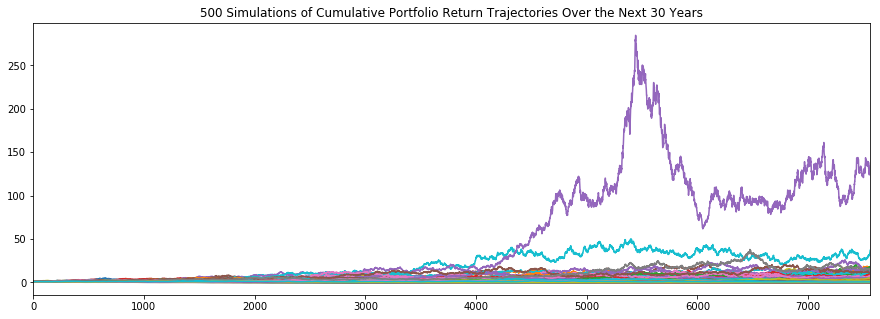

In [12]:
# Visualize the Simulation

monte_carlo_cum_returns_df.plot(legend=None, figsize=(15,5), title=f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years")

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
cum_returns_30 = monte_carlo_cum_returns_df.iloc[-1,:]
cum_returns_30.head()

0    0.491304
1    0.318769
2    0.355962
3    0.129668
4    0.348046
Name: 7560, dtype: float64

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
cum_returns_20 = monte_carlo_cum_returns_df.iloc[-11,:]
cum_returns_20.head()

0    0.185140
1    0.122331
2    0.119911
3    0.049387
4    0.134619
Name: 7550, dtype: float64

In [16]:
# Display the 90% confidence interval for the ending returns
ci90_20 = cum_returns_20.quantile(q=[0.05, 0.95])
ci90_30 = cum_returns_30.quantile(q=[0.05, 0.95])
print(f"Our 90% confidence interval for our 20-year portfolio return is {ci90_20}.")
print(f"Our 90% confidence interval for our 30-year portfolio return is {ci90_30}.")

Our 90% confidence interval for our 20-year portfolio return is 0.05    0.016472
0.95    2.483127
Name: 7550, dtype: float64.
Our 90% confidence interval for our 30-year portfolio return is 0.05    0.015814
0.95    2.483868
Name: 7560, dtype: float64.


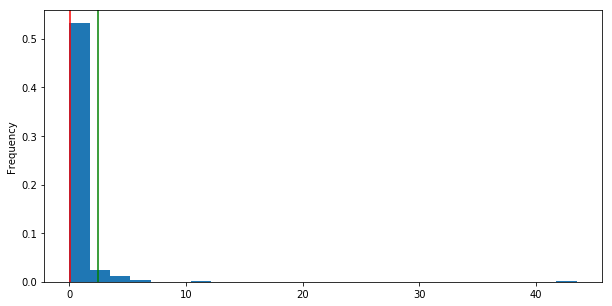

In [17]:
# Visualize the distribution of the ending returns
plt.figure();
cum_returns_20.plot.hist(density=True, figsize=(10,5), bins=25)
plt.axvline(ci90_20.iloc[0], color='r')
plt.axvline(ci90_20.iloc[1], color='g')

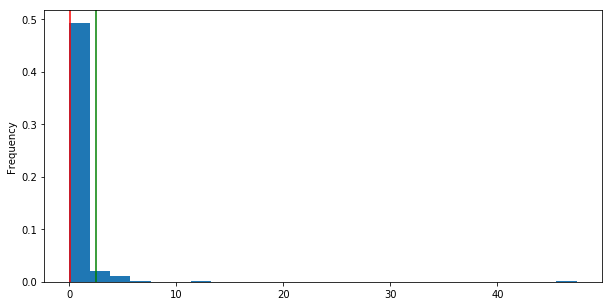

In [18]:
plt.figure();
cum_returns_30.plot.hist(density=True, figsize=(10,5), bins=25)
plt.axvline(ci90_30.iloc[0], color='r')
plt.axvline(ci90_30.iloc[1], color='g')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [19]:
ci10_30 = cum_returns_30.quantile(q=[0.45, 0.55])
ci50_30 = cum_returns_30.quantile(q=[0.25, 0.75])
print(ci10_30, ci50_30, ci90_30)
#The expected cumulative returns are between 

0.45    0.160922
0.55    0.250392
Name: 7560, dtype: float64 0.25    0.073254
0.75    0.585681
Name: 7560, dtype: float64 0.05    0.015814
0.95    2.483868
Name: 7560, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [20]:

investment = 20000

investment_lower_10 = investment + (investment * ci10_30.iloc[0])
investment_upper_10 = investment + (investment * ci10_30.iloc[1])

investment_lower_50 = investment + (investment * ci50_30.iloc[0])
investment_upper_50 = investment + (investment * ci50_30.iloc[1])

investment_lower_90 = investment + (investment * ci90_30.iloc[0])
investment_upper_90 = investment + (investment * ci90_30.iloc[1])

inv_lower_10 = round(investment_lower_10,2)
inv_upper_10 = round(investment_upper_10,2)
inv_lower_50 = round(investment_lower_50,2)
inv_upper_50 = round(investment_upper_50,2)
inv_lower_90 = round(investment_lower_90,2)
inv_upper_90 = round(investment_upper_90,2)



In [21]:
print(f"There is a 10% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_10:,} and ${inv_upper_10:,} in 30 years")
print(f"There is a 50% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_50:,} and ${inv_upper_50:,} in 30 years")
print(f"There is a 90% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_90:,} and ${inv_upper_90:,} in 30 years")

There is a 10% probability that an initial investment of $20,000 will produce a portfolio value between $23,218.45 and $25,007.84 in 30 years
There is a 50% probability that an initial investment of $20,000 will produce a portfolio value between $21,465.08 and $31,713.62 in 30 years
There is a 90% probability that an initial investment of $20,000 will produce a portfolio value between $20,316.29 and $69,677.37 in 30 years


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [22]:
#Interpreting the question as: if you retire in 30 years, can your annual income (assuming it remains constant) be replaced by an initial 4%
    #withdrawal from the portfolio at year 30.
#Assumption made:  
#If initial 4% withdrawal rate is sufficient after 30 years, it will remain so for the remainder of retirement.

annual_income = 6085
#projected net income as calculated in 'account_summary' file
withdrawal_lower_90 = round(inv_lower_90  *.04,2)
withdrawal_upper_90 = round(inv_upper_90 * .04,2)

print(withdrawal_lower_90, withdrawal_upper_90)   

812.65 2787.09


In [23]:
print(f"There is a 90% probability that a 4% withdrawal rate at year 30 will generate between ${withdrawal_lower_90:,} and ${withdrawal_upper_90:,}.")
print(f"Given projected annual net income of ${annual_income:,}, there a very strong probability that a 4% withdrawal at year 30 with an initial")
print(f"investment of ${investment:,} will not be sufficient to replace projected net income.")
print(f"Therefore, a larger initial investment and/or a significant reduction in expenses should be undertaken to allow a 4% withdrawal")
print(f"to fully substitute income after retirement.")

There is a 90% probability that a 4% withdrawal rate at year 30 will generate between $812.65 and $2,787.09.
Given projected annual net income of $6,085, there a very strong probability that a 4% withdrawal at year 30 with an initial
investment of $20,000 will not be sufficient to replace projected net income.
Therefore, a larger initial investment and/or a significant reduction in expenses should be undertaken to allow a 4% withdrawal
to fully substitute income after retirement.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
investment = 30000

investment_lower_10 = investment + (investment * ci10_30.iloc[0])
investment_upper_10 = investment + (investment * ci10_30.iloc[1])

investment_lower_50 = investment + (investment * ci50_30.iloc[0])
investment_upper_50 = investment + (investment * ci50_30.iloc[1])

investment_lower_90 = investment + (investment * ci90_30.iloc[0])
investment_upper_90 = investment + (investment * ci90_30.iloc[1])

inv_lower_10 = round(investment_lower_10,2)
inv_upper_10 = round(investment_upper_10,2)
inv_lower_50 = round(investment_lower_50,2)
inv_upper_50 = round(investment_upper_50,2)
inv_lower_90 = round(investment_lower_90,2)
inv_upper_90 = round(investment_upper_90,2)

print(f"There is a 10% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_10:,} and ${inv_upper_10:,} in 30 years")
print(f"There is a 50% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_50:,} and ${inv_upper_50:,} in 30 years")
print(f"There is a 90% probability that an initial investment of ${investment:,} will produce a portfolio value between ${inv_lower_90:,} and ${inv_upper_90:,} in 30 years")

There is a 10% probability that an initial investment of $30,000 will produce a portfolio value between $34,827.67 and $37,511.76 in 30 years
There is a 50% probability that an initial investment of $30,000 will produce a portfolio value between $32,197.62 and $47,570.43 in 30 years
There is a 90% probability that an initial investment of $30,000 will produce a portfolio value between $30,474.43 and $104,516.05 in 30 years


In [25]:
annual_income = 6085
#projected net income as calculated in 'account_summary' file
withdrawal_lower_90 = round(inv_lower_90  *.04,2)
withdrawal_upper_90 = round(inv_upper_90 * .04,2)

print(withdrawal_lower_90, withdrawal_upper_90) 

1218.98 4180.64


In [26]:
print(f"There is a 90% probability that a 4% withdrawal rate at year 30 will generate between ${withdrawal_lower_90:,} and ${withdrawal_upper_90:,}.")
print(f"Given projected annual net income of ${annual_income:,}, there a very strong probability that a 4% withdrawal at year 30 with an initial")
print(f"investment of ${investment:,} will not be sufficient to replace projected net income.")
print(f"Therefore, a larger initial investment and/or a significant reduction in expenses should be undertaken to allow a 4% withdrawal")
print(f"to fully substitute income after retirement.")

There is a 90% probability that a 4% withdrawal rate at year 30 will generate between $1,218.98 and $4,180.64.
Given projected annual net income of $6,085, there a very strong probability that a 4% withdrawal at year 30 with an initial
investment of $30,000 will not be sufficient to replace projected net income.
Therefore, a larger initial investment and/or a significant reduction in expenses should be undertaken to allow a 4% withdrawal
to fully substitute income after retirement.


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE